In [22]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the dataset
#Load the sticker dataset
df = pd.read_parquet('../data/processed_sticker_dataset.parquet')

# Convert embeddings to float32 numpy array
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

Using device: cpu


In [24]:
class StickerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.dataframe.iloc[idx]['combined_embedding']).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]['image_path']).float()
        return embedding, image_tensor


In [25]:
dataset = StickerDataset(df)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [26]:
class Generator(nn.Module):
    def __init__(self, noise_dim, embedding_dim, image_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_channels * 32 * 32),
            nn.Tanh()
        )

    def forward(self, noise, embed):
        x = torch.cat((noise, embed), dim=1)
        x = self.model(x)
        return x.view(x.size(0), 3, 32, 32)

In [27]:
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, image_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_channels * 32 * 32 + embedding_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, embed):
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, embed), dim=1)
        return self.model(x)


In [28]:
noise_dim = 100
embedding_dim = len(df['combined_embedding'][0])
generator = Generator(noise_dim, embedding_dim).to(device)
discriminator = Discriminator(embedding_dim).to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

num_epochs = 50

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    for embeddings, real_images in progress_bar:
        embeddings, real_images = embeddings.to(device), real_images.to(device)
        
        # Train Discriminator
        noise = torch.randn(real_images.size(0), noise_dim).to(device)
        fake_images = generator(noise, embeddings)
        
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        real_outputs = discriminator(real_images, embeddings)
        fake_outputs = discriminator(fake_images.detach(), embeddings)
        
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        fake_outputs = discriminator(fake_images, embeddings)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 1/50: 100%|██████████| 607/607 [34:47<00:00,  3.44s/it]


Epoch [1/50] | D Loss: 0.0969 | G Loss: 3.7300


Epoch 2/50: 100%|██████████| 607/607 [01:22<00:00,  7.32it/s]


Epoch [2/50] | D Loss: 0.0672 | G Loss: 5.4709


Epoch 3/50: 100%|██████████| 607/607 [01:21<00:00,  7.42it/s]


Epoch [3/50] | D Loss: 0.4768 | G Loss: 1.3575


Epoch 4/50: 100%|██████████| 607/607 [01:22<00:00,  7.36it/s]


Epoch [4/50] | D Loss: 0.2580 | G Loss: 2.8541


Epoch 5/50: 100%|██████████| 607/607 [01:26<00:00,  7.05it/s]


Epoch [5/50] | D Loss: 0.0384 | G Loss: 4.8491


Epoch 6/50: 100%|██████████| 607/607 [01:25<00:00,  7.10it/s]


Epoch [6/50] | D Loss: 0.0664 | G Loss: 6.1746


Epoch 7/50: 100%|██████████| 607/607 [01:25<00:00,  7.13it/s]


Epoch [7/50] | D Loss: 0.0442 | G Loss: 5.3578


Epoch 8/50: 100%|██████████| 607/607 [01:26<00:00,  7.02it/s]


Epoch [8/50] | D Loss: 0.0736 | G Loss: 4.2976


Epoch 9/50: 100%|██████████| 607/607 [01:27<00:00,  6.94it/s]


Epoch [9/50] | D Loss: 0.8109 | G Loss: 3.6059


Epoch 10/50: 100%|██████████| 607/607 [01:26<00:00,  6.99it/s]


Epoch [10/50] | D Loss: 0.4658 | G Loss: 3.1492


Epoch 11/50: 100%|██████████| 607/607 [01:25<00:00,  7.12it/s]


Epoch [11/50] | D Loss: 0.4688 | G Loss: 2.9219


Epoch 12/50: 100%|██████████| 607/607 [01:24<00:00,  7.21it/s]


Epoch [12/50] | D Loss: 0.5656 | G Loss: 2.1513


Epoch 13/50: 100%|██████████| 607/607 [01:25<00:00,  7.12it/s]


Epoch [13/50] | D Loss: 0.5967 | G Loss: 3.4389


Epoch 14/50: 100%|██████████| 607/607 [01:25<00:00,  7.13it/s]


Epoch [14/50] | D Loss: 0.6340 | G Loss: 2.0507


Epoch 15/50: 100%|██████████| 607/607 [01:24<00:00,  7.15it/s]


Epoch [15/50] | D Loss: 0.4416 | G Loss: 2.3843


Epoch 16/50: 100%|██████████| 607/607 [01:26<00:00,  7.03it/s]


Epoch [16/50] | D Loss: 0.4919 | G Loss: 2.8512


Epoch 17/50: 100%|██████████| 607/607 [01:24<00:00,  7.20it/s]


Epoch [17/50] | D Loss: 0.6880 | G Loss: 2.8504


Epoch 18/50: 100%|██████████| 607/607 [01:24<00:00,  7.20it/s]


Epoch [18/50] | D Loss: 0.6931 | G Loss: 1.9982


Epoch 19/50: 100%|██████████| 607/607 [01:25<00:00,  7.06it/s]


Epoch [19/50] | D Loss: 0.6424 | G Loss: 2.4108


Epoch 20/50: 100%|██████████| 607/607 [01:25<00:00,  7.11it/s]


Epoch [20/50] | D Loss: 0.7015 | G Loss: 2.0870


Epoch 21/50: 100%|██████████| 607/607 [01:24<00:00,  7.20it/s]


Epoch [21/50] | D Loss: 0.9127 | G Loss: 2.3763


Epoch 22/50: 100%|██████████| 607/607 [01:24<00:00,  7.18it/s]


Epoch [22/50] | D Loss: 0.5902 | G Loss: 2.0321


Epoch 23/50: 100%|██████████| 607/607 [01:25<00:00,  7.11it/s]


Epoch [23/50] | D Loss: 0.7542 | G Loss: 2.2810


Epoch 24/50: 100%|██████████| 607/607 [01:30<00:00,  6.72it/s]


Epoch [24/50] | D Loss: 1.0201 | G Loss: 1.7145


Epoch 25/50: 100%|██████████| 607/607 [01:33<00:00,  6.47it/s]


Epoch [25/50] | D Loss: 0.6786 | G Loss: 2.2269


Epoch 26/50: 100%|██████████| 607/607 [01:35<00:00,  6.37it/s]


Epoch [26/50] | D Loss: 0.6366 | G Loss: 2.9267


Epoch 27/50: 100%|██████████| 607/607 [01:25<00:00,  7.06it/s]


Epoch [27/50] | D Loss: 0.8333 | G Loss: 2.6088


Epoch 28/50: 100%|██████████| 607/607 [01:27<00:00,  6.91it/s]


Epoch [28/50] | D Loss: 0.7578 | G Loss: 2.2849


Epoch 29/50: 100%|██████████| 607/607 [01:29<00:00,  6.78it/s]


Epoch [29/50] | D Loss: 0.7640 | G Loss: 1.9708


Epoch 30/50: 100%|██████████| 607/607 [01:27<00:00,  6.90it/s]


Epoch [30/50] | D Loss: 1.2057 | G Loss: 3.0869


Epoch 31/50: 100%|██████████| 607/607 [01:30<00:00,  6.70it/s]


Epoch [31/50] | D Loss: 0.5640 | G Loss: 2.3173


Epoch 32/50: 100%|██████████| 607/607 [01:30<00:00,  6.71it/s]


Epoch [32/50] | D Loss: 0.6043 | G Loss: 3.2343


Epoch 33/50: 100%|██████████| 607/607 [01:30<00:00,  6.73it/s]


Epoch [33/50] | D Loss: 1.1851 | G Loss: 2.1683


Epoch 34/50: 100%|██████████| 607/607 [01:31<00:00,  6.63it/s]


Epoch [34/50] | D Loss: 0.8519 | G Loss: 2.5423


Epoch 35/50: 100%|██████████| 607/607 [01:34<00:00,  6.41it/s]


Epoch [35/50] | D Loss: 1.0510 | G Loss: 1.9699


Epoch 36/50: 100%|██████████| 607/607 [01:28<00:00,  6.90it/s]


Epoch [36/50] | D Loss: 1.2172 | G Loss: 2.5416


Epoch 37/50: 100%|██████████| 607/607 [01:28<00:00,  6.89it/s]


Epoch [37/50] | D Loss: 0.9574 | G Loss: 1.4577


Epoch 38/50: 100%|██████████| 607/607 [01:35<00:00,  6.33it/s]


Epoch [38/50] | D Loss: 0.8397 | G Loss: 2.3294


Epoch 39/50: 100%|██████████| 607/607 [01:31<00:00,  6.63it/s]


Epoch [39/50] | D Loss: 1.0712 | G Loss: 1.8301


Epoch 40/50: 100%|██████████| 607/607 [01:29<00:00,  6.81it/s]


Epoch [40/50] | D Loss: 1.2595 | G Loss: 1.7961


Epoch 41/50: 100%|██████████| 607/607 [01:28<00:00,  6.85it/s]


Epoch [41/50] | D Loss: 0.7519 | G Loss: 1.9439


Epoch 42/50: 100%|██████████| 607/607 [01:29<00:00,  6.78it/s]


Epoch [42/50] | D Loss: 0.8678 | G Loss: 1.9623


Epoch 43/50: 100%|██████████| 607/607 [01:29<00:00,  6.75it/s]


Epoch [43/50] | D Loss: 0.9741 | G Loss: 1.4462


Epoch 44/50: 100%|██████████| 607/607 [01:29<00:00,  6.79it/s]


Epoch [44/50] | D Loss: 0.9639 | G Loss: 2.6865


Epoch 45/50: 100%|██████████| 607/607 [01:27<00:00,  6.92it/s]


Epoch [45/50] | D Loss: 0.7368 | G Loss: 2.3780


Epoch 46/50: 100%|██████████| 607/607 [01:27<00:00,  6.94it/s]


Epoch [46/50] | D Loss: 0.9286 | G Loss: 3.2116


Epoch 47/50: 100%|██████████| 607/607 [01:27<00:00,  6.91it/s]


Epoch [47/50] | D Loss: 0.7068 | G Loss: 1.8296


Epoch 48/50: 100%|██████████| 607/607 [01:27<00:00,  6.95it/s]


Epoch [48/50] | D Loss: 0.9138 | G Loss: 2.3455


Epoch 49/50: 100%|██████████| 607/607 [01:28<00:00,  6.89it/s]


Epoch [49/50] | D Loss: 0.9434 | G Loss: 2.1238


Epoch 50/50: 100%|██████████| 607/607 [01:27<00:00,  6.94it/s]

Epoch [50/50] | D Loss: 0.8779 | G Loss: 1.8744


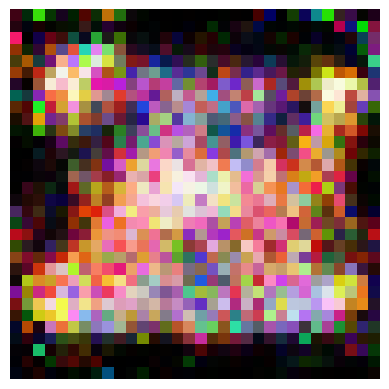

In [ ]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('all-MiniLM-L6-v2').to(device)

def generate_stickers(descriptions, generator):
    generator.eval()
    stickers = []
    for description in descriptions:
        embedding = sbert_model.encode(description)
        embedding = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)
        noise = torch.randn(1, noise_dim).to(device)
        with torch.no_grad():
            fake_image = generator(noise, embedding).squeeze(0).cpu().numpy()
        stickers.append(fake_image)
    return stickers

def display_stickers(images):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 3, 3))
    for ax, image in zip(axes, images):
        image = (image + 1) / 2  # Normalize to [0,1]
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.axis("off")
    plt.show()

# Example: Generate & Display Multiple Stickers
descriptions = ["A happy sun wearing sunglasses", "A cute panda waving", "A colorful unicorn smiling"]
stickers = generate_stickers(descriptions, generator)
display_stickers(stickers)